In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
from functools import partial

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from src.config import Config
from src.episode import Episode
from src.episode_dataset import EpisodeDataset
from src.policy import Policy
from src.reward_model import RewardModel
from src.grpo_trainer import GRPOTrainer
from src.utils import get_color, normalize_min_max, to_device_collate, top_k_sampling
from src.episode_batch_reat_sampler import EpisodeBatchRepeatSampler

# Setup
---

In [2]:
config = Config()
reward_model = RewardModel(config=config)

# Datasets

train_dataset = EpisodeDataset(config=config, split="TRAIN")
print(f"train_dataset : {len(train_dataset)}")

test_dataset = EpisodeDataset(config=config, split="TEST")
print(f"test_dataset : {len(test_dataset)}")

eval_dataset = EpisodeDataset(config=config, split="EVAL")
print(f"eval_dataset : {len(eval_dataset)}")


# DataLoaders
def get_data_loader(dataset: EpisodeDataset, batch_size: int, repeats: int):
    batch_repeat_sampler = EpisodeBatchRepeatSampler(
        dataset=dataset,
        batch_size=batch_size,
        repeats=repeats,
    )
    print(f"batch_repeat_sampler: {list(batch_repeat_sampler)}")

    to_device_collate_configurable = partial(to_device_collate, config.device)
    dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=batch_repeat_sampler,
        collate_fn=to_device_collate_configurable,
    )
    return dataloader


train_dataloader = get_data_loader(
    dataset=train_dataset,
    batch_size=config.train_batch_size,
    repeats=config.episode_steps,
)
test_dataloader = get_data_loader(
    dataset=test_dataset,
    batch_size=config.test_batch_size,
    repeats=config.episode_steps,
)

eval_dataloader = get_data_loader(
    dataset=eval_dataset,
    batch_size=config.eval_batch_size,
    repeats=config.episode_steps,
)

train_dataset : 100
test_dataset : 2000
eval_dataset : 100
batch_repeat_sampler: [46, 48, 44, 4, 90, 76, 32, 71, 27, 38, 81, 53, 0, 12, 99, 43, 64, 54, 69, 11, 26, 67, 82, 17, 62, 98, 41, 1, 96, 7, 83, 91, 85, 36, 2, 86, 8, 92, 21, 49, 70, 40, 93, 79, 18, 95, 14, 9, 33, 20, 46, 48, 44, 4, 90, 76, 32, 71, 27, 38, 81, 53, 0, 12, 99, 43, 64, 54, 69, 11, 26, 67, 82, 17, 62, 98, 41, 1, 96, 7, 83, 91, 85, 36, 2, 86, 8, 92, 21, 49, 70, 40, 93, 79, 18, 95, 14, 9, 33, 20, 46, 48, 44, 4, 90, 76, 32, 71, 27, 38, 81, 53, 0, 12, 99, 43, 64, 54, 69, 11, 26, 67, 82, 17, 62, 98, 41, 1, 96, 7, 83, 91, 85, 36, 2, 86, 8, 92, 21, 49, 70, 40, 93, 79, 18, 95, 14, 9, 33, 20, 46, 48, 44, 4, 90, 76, 32, 71, 27, 38, 81, 53, 0, 12, 99, 43, 64, 54, 69, 11, 26, 67, 82, 17, 62, 98, 41, 1, 96, 7, 83, 91, 85, 36, 2, 86, 8, 92, 21, 49, 70, 40, 93, 79, 18, 95, 14, 9, 33, 20, 46, 48, 44, 4, 90, 76, 32, 71, 27, 38, 81, 53, 0, 12, 99, 43, 64, 54, 69, 11, 26, 67, 82, 17, 62, 98, 41, 1, 96, 7, 83, 91, 85, 36, 2, 86, 8, 92, 

fov: torch.Size([5, 5]), tensor([[200., 255., 255., 255., 150.],
        [200., 255., 255., 150., 255.],
        [200., 255., 128., 150., 255.],
        [255., 255., 151., 150., 255.],
        [255., 255., 152., 255., 255.]])


TypeError: Episode.viz_fov() got an unexpected keyword argument 'center_pos'

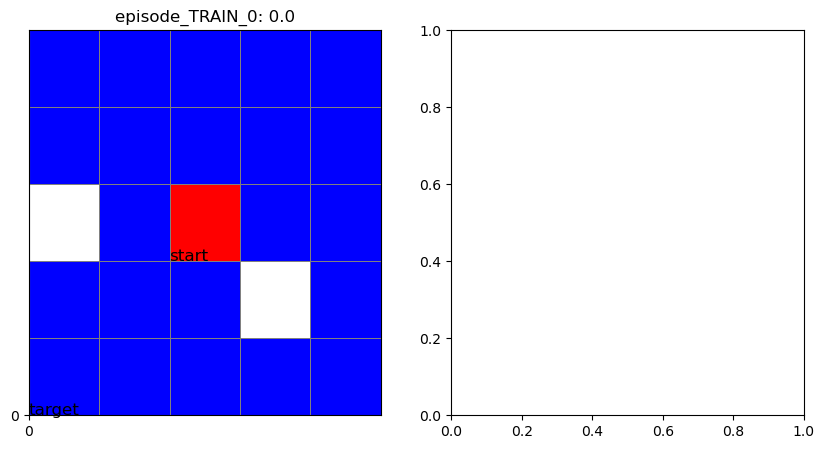

In [ ]:
episode1 = train_dataset.episodes[0]

# Viz world
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
episode1.viz(ax=axes[0], reward_model=reward_model)

# Viz fov
fov = episode1.fov(center_pos=episode1.agent.start_state.position())
print(f"fov: {fov.size()}, {fov}")
# print(f"fov: {fov}")
episode1.viz_fov(ax=axes[1])
plt.show()

In [4]:
def train_and_plot_policy(policy: Policy, debug: bool = False):
    episode = Episode.new(id="train")
    print(f"start: {episode.agent.current_state}")
    episode.train(steps=20, policy=policy, debug=debug)
    print(f"start2: {episode.agent.current_state}")

    fig = plt.figure(figsize=config.figure_size)
    ax = fig.add_subplot(1, 1, 1)
    episode.viz(ax=ax, reward_model=reward_model, color=get_color(0))
    plt.show()

    return episode


def inference_and_plot_policy(policy: Policy, steps: int = 20, debug: bool = False):
    episode = Episode.new(id="inference")
    # print(f"start state: {episode.agent.start_state}")
    # print(f"target state: {episode.agent.target_state}")
    episode.inference_steps_by_policy(steps=steps, policy=policy, debug=debug)
    # print(f"end state: {episode.agent.current_state}")

    fig = plt.figure(figsize=config.figure_size)
    ax = fig.add_subplot(1, 1, 1)
    episode.viz(ax=ax, reward_model=reward_model, color=get_color(0))
    plt.show()

    return episode

step: 0, logits: tensor([[-364.2218,   94.9348,   92.0293,  341.8921, -873.6058,  -53.1996,
         -116.6089,  577.8764, -275.9483]]), logit_prob: tensor([[0.1668]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[7]]), state: tensor([3, 2]), action_history: [tensor(7)]
step: 1, logits: tensor([[-365.0281, -103.8976,  -36.3999,  245.1226, -572.9363,  -72.8973,
           41.2619,  608.9742, -367.7115]]), logit_prob: tensor([[0.1892]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[7]]), state: tensor([4, 2]), action_history: [tensor(7), tensor(7)]
step: 2, logits: tensor([[-677.0873,  150.7059,   21.1283,  182.7583, -271.1585,  -23.5039,
         -262.5528,  121.8242, -169.8342]]), logit_prob: tensor([[0.1486]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[3]]), state: tensor([4, 1]), action_history: [tensor(7), tensor(7), tensor(3)]
step: 3, logits: tensor([[-303.2180,  -19.4325,  268.0634,  250.0313, -255.9534,  111.4475,
          -93.1906,  301.4423, -162.9242]]), logit

/Users/chengbai/ml/cheng_git/rf_agent/src/reward_model.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dxy = torch.tensor(action.get_udpate())


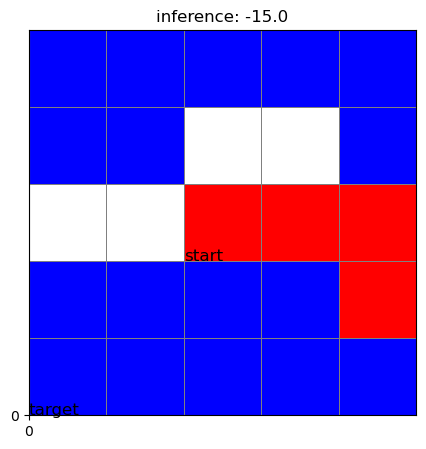

In [5]:
test_policy = Policy(config=config)
episode = inference_and_plot_policy(policy=test_policy, steps=5, debug=True)
# episode.agent.action_history

# Training Loop
---

In [6]:
policy = Policy(config=config)
reward_model = RewardModel(config=config)
trainer = GRPOTrainer(config=config, policy=policy, reward_model=reward_model)

step: 0, logits: tensor([[-698.3828,  154.2110,  -73.8829,  300.4791, -715.1245,  -82.7235,
         -103.5801,  438.3063, -218.2928]]), logit_prob: tensor([[0.1701]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[7]]), state: tensor([3, 2]), action_history: [tensor(7)]
step: 1, logits: tensor([[-447.2142,    2.1962,    9.0694,  305.7532, -460.8290,  -51.3705,
          -36.9419,  375.8646, -260.6502]]), logit_prob: tensor([[0.1778]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[7]]), state: tensor([4, 2]), action_history: [tensor(7), tensor(7)]
step: 2, logits: tensor([[-470.4587,   87.5313,  -21.2913,  182.4289, -365.7560,    5.2750,
         -255.5167,  169.0057, -308.6075]]), logit_prob: tensor([[0.1634]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[3]]), state: tensor([4, 1]), action_history: [tensor(7), tensor(7), tensor(3)]
step: 3, logits: tensor([[-579.1585,   74.1947,  129.8469,  236.6478, -304.2993,   52.9054,
          -52.1131,  123.8062, -233.0337]]), logit

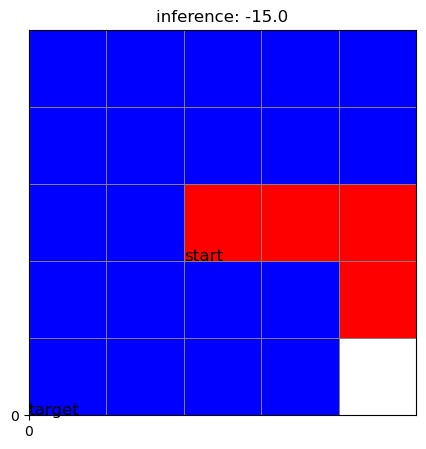

In [7]:
# Before tarin, policy behavior
episode = inference_and_plot_policy(policy=test_policy, steps=5, debug=True)

In [8]:
# plt.ioff()
trainer.run(train_dataset=train_dataset, eval_dataset=eval_dataset, debug=False)
# plt.ion()

batch_repeat_sampler: [88, 55, 93, 5, 10, 40, 64, 87, 80, 0, 84, 17, 58, 60, 47, 23, 19, 28, 67, 74, 50, 68, 65, 97, 70, 6, 12, 61, 3, 33, 77, 13, 56, 57, 14, 35, 1, 53, 73, 27, 91, 45, 36, 26, 34, 46, 75, 42, 43, 81, 88, 55, 93, 5, 10, 40, 64, 87, 80, 0, 84, 17, 58, 60, 47, 23, 19, 28, 67, 74, 50, 68, 65, 97, 70, 6, 12, 61, 3, 33, 77, 13, 56, 57, 14, 35, 1, 53, 73, 27, 91, 45, 36, 26, 34, 46, 75, 42, 43, 81, 88, 55, 93, 5, 10, 40, 64, 87, 80, 0, 84, 17, 58, 60, 47, 23, 19, 28, 67, 74, 50, 68, 65, 97, 70, 6, 12, 61, 3, 33, 77, 13, 56, 57, 14, 35, 1, 53, 73, 27, 91, 45, 36, 26, 34, 46, 75, 42, 43, 81, 88, 55, 93, 5, 10, 40, 64, 87, 80, 0, 84, 17, 58, 60, 47, 23, 19, 28, 67, 74, 50, 68, 65, 97, 70, 6, 12, 61, 3, 33, 77, 13, 56, 57, 14, 35, 1, 53, 73, 27, 91, 45, 36, 26, 34, 46, 75, 42, 43, 81, 88, 55, 93, 5, 10, 40, 64, 87, 80, 0, 84, 17, 58, 60, 47, 23, 19, 28, 67, 74, 50, 68, 65, 97, 70, 6, 12, 61, 3, 33, 77, 13, 56, 57, 14, 35, 1, 53, 73, 27, 91, 45, 36, 26, 34, 46, 75, 42, 43, 81, 88

/Users/chengbai/ml/cheng_git/rf_agent/src/reward_model.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dxy = torch.tensor(action.get_udpate())
/Users/chengbai/ml/cheng_git/rf_agent/src/reward_model.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dxy = torch.tensor(action.get_udpate())


step: 0, logits: tensor([[ 4.7704e+11,  4.9407e+11,  4.9838e+11, -2.4566e+11, -3.6498e+11,
          4.7950e+11,  4.1882e+11, -4.9385e+11,  4.8020e+11]]), logit_prob: tensor([[0.1405]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[2]]), state: tensor([1, 3]), action_history: [tensor(2)]
step: 1, logits: tensor([[ 2.8540e+11,  2.9784e+11,  3.0013e+11, -1.4647e+11, -2.1842e+11,
          2.8723e+11,  2.5191e+11, -2.9669e+11,  2.8902e+11]]), logit_prob: tensor([[0.1406]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[2]]), state: tensor([1, 3]), action_history: [tensor(2)]
step: 2, logits: tensor([[ 2.8540e+11,  2.9784e+11,  3.0013e+11, -1.4647e+11, -2.1842e+11,
          2.8723e+11,  2.5191e+11, -2.9669e+11,  2.8902e+11]]), logit_prob: tensor([[0.1406]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[2]]), state: tensor([1, 3]), action_history: [tensor(2)]
step: 3, logits: tensor([[ 2.8540e+11,  2.9784e+11,  3.0013e+11, -1.4647e+11, -2.1842e+11,
          2.8723e+11,  2.5191e

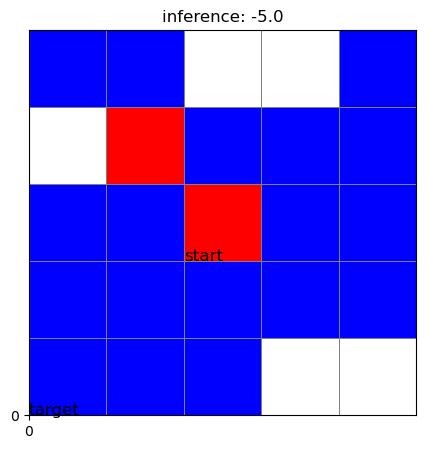

episode reward: -5.0


In [9]:
episode = inference_and_plot_policy(
    policy=policy, steps=config.episode_steps, debug=True
)
print(f"episode reward: {episode.reward(reward_model=reward_model)}")